<a href="https://colab.research.google.com/github/clementtoun/OpenGLTP/blob/main/Efficiently_Locating_Objects_Using_the_Haudorff_Distance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, feature
from scipy import ndimage
import math

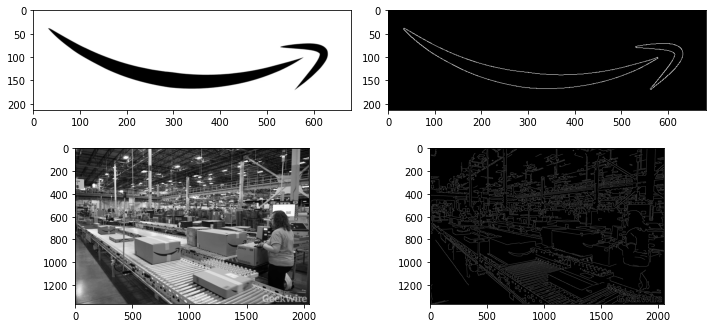

In [4]:
amazon_logo   = io.imread('./model/Amazon_logo.png', as_gray=True)
amazon_center = io.imread('./image/Amazon_center.png', as_gray=True)

canny_logo = feature.canny(amazon_logo)
canny_center = feature.canny(amazon_center, sigma=3)

fig, axs = plt.subplots(2, 2 , figsize=(10, 5))

axs[0,0].imshow(amazon_logo, cmap='gray')
axs[0,1].imshow(canny_logo, cmap='gray')
axs[1,0].imshow(amazon_center, cmap='gray')
axs[1,1].imshow(canny_center, cmap='gray')

fig.tight_layout()
fig.show()

(1365, 2048)


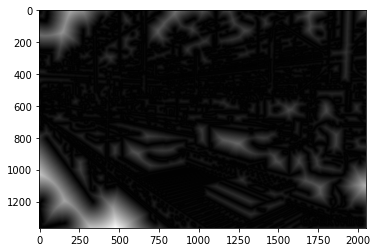

In [5]:
distance_transform_I = ndimage.distance_transform_edt(1 - canny_center)
print(distance_transform_I.shape)

plt.imshow(distance_transform_I, cmap='gray')
plt.show()

In [6]:
def transform(points, a00, a01, a10, a11, tx, ty):
  points_transform = []
  for (x,y) in points:
    points_transform.append((a00*x + a01*y + tx, a10*x + a11*y + ty))

  return points_transform

In [7]:
def gen_image_transform(points_transform, xmax, ymax):
  image_transform = np.zeros((xmax, ymax))

  for (x,y) in points_transform:
    x, y = round(x), round(y)
    if 0 <= x and x < image_transform.shape[0] and 0 <= y and y < image_transform.shape[1]:
      image_transform[x, y] = 1

  return image_transform

# Box-Distance Transform
see part 4.2

In [8]:
def delta(x, y, I) :
    return np.linalg.norm([x, y] - I, axis=1).min() # min des i, x et y sont fixes
    

def box_distance_transform(cell, M, I) :
    # calcul top-left & bottom-right corners
    tlc, brc = cell

    w = brc[0] + brc[1] + brc[4] - tlc[0] - tlc[1] - tlc[4] # x-linked dim
    h = brc[2] + brc[3] + brc[5] - tlc[2] - tlc[3] - tlc[5] # y-linked dim
    X, Y = (np.arange(0, w+1), np.arange(0, h+1)) # x', y'

    box_distance = np.zeros(M.shape[0])
    for i in range(M.shape[0]): 
        x, y = M[i] # x, y fixe 
        X_, Y_ = X + x, Y + y # x + x', y + y'
        box_distance[i] = min([delta(x, y, I) for (x, y) in zip(X_, Y_)])
    return box_distance

In [9]:
def box_distance_transform2(cell, M, distance_transform, tof):
    # calcul top-left & bottom-right corners
    tlc, brc = cell

    w = brc[0] + brc[1] + brc[4] - tlc[0] - tlc[1] - tlc[4] # x-linked dim
    h = brc[2] + brc[3] + brc[5] - tlc[2] - tlc[3] - tlc[5] # y-linked dim

    box_distance = np.zeros(M.shape[0])
    for i, (x, y) in enumerate(M): 
      wx = x + w
      wx = wx if wx < distance_transform.shape[0] else w
      hy = y + h
      hy = hy if hy < distance_transform.shape[1] else h
      box_distance[i] = np.min(distance_transform[x:wx+1, y:hy+1]) <= tof

    return box_distance

In [37]:
import time

#points = liste de tuple 
#M = image model 1 = point interêt / 0 sinon
#I = image 1 = point interêt / 0 sinon
def localisation(M, I, tof, tor, ff, fr, d_min, d_max, alpha_max, s_max):
  r = 2

  distance_transform_I = ndimage.distance_transform_edt(1 - I)

  M_points_interet = np.array(list(zip(*np.nonzero(M))))

  cells = [(np.array([0,0,0,0,0,0]), np.array([I.shape[0], I.shape[0], I.shape[1], I.shape[1], I.shape[0], I.shape[1]]))]

  finer_cells = []

  while(cells != []):
    cell = cells[0]
    box_distance = box_distance_transform2(cell, M_points_interet, distance_transform_I, tof)
    if np.count_nonzero(box_distance) / M.shape[0] >= ff:
      #cellule intéréssante
      tlc, brc = cell
      cell_size = (brc - tlc)
      if np.all(cell_size <= 2):
        finer_cells.append(cell)
      else:
        new_cell_bound = np.copy(tlc)
        for i in range(6):
          if cell_size[i] // 2 > 1:
            new_cell_bound[i] += np.ceil(cell_size[i] / r).astype(int)
        cells.append((tlc, new_cell_bound))
        cells.append((new_cell_bound, brc))
    del cells[0]

  print('here')

  transforms = []

  i = 0
  for cell in finer_cells:

    for a00 in range(cell[0][0], cell[1][0]):
      for a01 in range(cell[0][1], cell[1][1]):
        for a10 in range(cell[0][2], cell[1][2]):
          for a11 in range(cell[0][3], cell[1][3]):
            for tx in range(cell[0][4], cell[1][4]):
              for ty in range(cell[0][5], cell[1][5]):

                d = a00 * a11 - a01 * a10 
                if d < d_min or d > d_max:
                  break 

                d_a00_a01 = np.sqrt(a00*a00 + a10*a10)
                d_a01_a11 = np.sqrt(a01*a01 + a11*a11)
                alpha = max(d_a00_a01/d_a01_a11, d_a01_a11/d_a00_a01)
                s = abs(a00*a01+a10*a11) / (d_a00_a01*d_a01_a11)
                if alpha > alpha_max or s > s_max:
                  break

                transforms.append(np.array([a00, a01, a10, a11, tx, ty]))

  return transforms

In [35]:
xmax, ymax = canny_logo.shape[0], canny_logo.shape[1]

tof = np.sqrt(5)

M = np.array(list(zip(*np.nonzero(canny_logo))))
print(M.shape)

I = np.array(list(zip(*np.nonzero(canny_center))))

cells = [(np.array([0,0,0,0,0,0]), np.array([xmax, xmax, ymax, ymax, xmax, ymax]))]

start = time.time()
box_distance = box_distance_transform2(cells[0], M, distance_transform_I, tof)
count = np.count_nonzero(box_distance)

print(time.time() - start)

print(count / M.shape[0])
print(np.unique(box_distance))

r = 2

(1713, 2)
2.8401548862457275
1.0
[1.]


In [38]:
tof = tor = np.sqrt(5)
ff = 1
fr = 0.8
d_min = 0.3
d_max = 1
alpha_max = 2
s_max = 1

transforms = localisation(canny_logo, canny_center, tof, tor, ff, fr, d_min, d_max, alpha_max, s_max)

KeyboardInterrupt: ignored

In [ ]:
print(len(transforms))

xmax, ymax = canny_center.shape[0], canny_center.shape[1]

base = np.array([1/xmax, 1/xmax, 1/ymax, 1/ymax, 1, 1])

idx = 2000
trans = transforms[idx] * base
print(trans)
points_transform = transform(M, *trans)

image_test = gen_image_transform(points_transform, canny_center.shape[0], canny_center.shape[1])

plt.imshow(image_test, cmap='gray')
plt.show()

# Distance de Haursdorff

In [ ]:
def Haursdorff(model, image, ff, fr, tof, tor) :
  # 1 - partial forward Hausdorff distance.
  # Cell-division <=> a cell must satisfy the forward criterion f[t] >= ff   
  ### hff = todo
  # 2 - partial box-reverse Hausdorff distance
  ### hfrbox = todo
  # 3 - Hausdorff distance
  # return max(hff, hfrbox)
  pass